In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPooling2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
!apt-get update -qq && apt-get install -y qq wget unzip
!rm -rf cats_and_dogs.zip && rm -rf cats_and_dogs
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
!ls -lah
!unzip -o cats_and_dogs.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.119.jpg  
  inflating: cats_and_dogs/train/dogs/dog.74.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.74.jpg  
  inflating: cats_and_dogs/train/dogs/dog.60.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_do

In [19]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH,'train')
validation_dir = os.path.join(PATH,'validation')
test_dir = os.path.join(PATH,'test')

total_train = sum([len(files) for r,d,files in os.walk(train_dir)])
total_val = sum([len(files) for r,d,files in os.walk(validation_dir)])
total_text = len(os.listdir(test_dir))

batch_size = 128
epochs = 50
IMG_HEIGHT = 150
IMG_WIDTH = 150



In [20]:



rescale=1/255

train_img_generator = ImageDataGenerator(rescale=rescale)
validation_img_generator = ImageDataGenerator(rescale=rescale)
test_img_generator = ImageDataGenerator(rescale=rescale)

train_data_gen = train_img_generator.flow_from_directory(
    batch_size = batch_size,
    directory = train_dir,
    target_size = (IMG_HEIGHT,IMG_WIDTH),
    class_mode = 'binary'

)
val_data_gen = validation_img_generator.flow_from_directory(
    batch_size = batch_size,
    directory = validation_dir,
    target_size = (IMG_HEIGHT,IMG_WIDTH),
    class_mode = 'binary'

)
test_data_gen = test_img_generator.flow_from_directory(
    batch_size = batch_size,
    classes=["."],
    directory = test_dir,
    target_size = (IMG_HEIGHT,IMG_WIDTH),
    shuffle = False,
    class_mode = 'binary'

)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


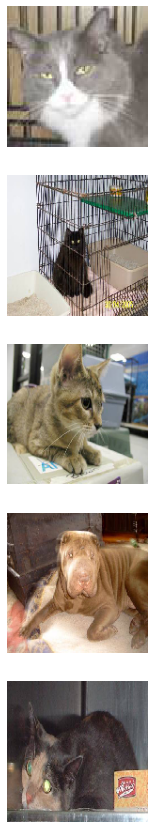

In [21]:
def plotImages(images_arr,probabilities = False):
  fig,axes = plt.subplots(len(images_arr),1,figsize=(5,len(images_arr)*3))
  if probabilities is False:
    for img,ax in  zip(images_arr,axes):
      ax.imshow(img)
      ax.axis('off')
  else:
    for img,probability,ax in zip(images_arr,probabilities,axes):
      ax.imshow(img)
      ax.axis('off')
      if probability > 0.5:
        ax.set_title("%.2f" % (probability*100) + "% dog")
      else:
        ax.set_title("%.2f" % ((1-probability)*100) + "% cat")

  plt.show()

sample_training_images,_ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [22]:
train_image_generator = ImageDataGenerator(
    rescale=rescale,
    horizontal_flip = True,
    rotation_range = 20,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    fill_mode = "nearest"
)

Found 2000 images belonging to 2 classes.


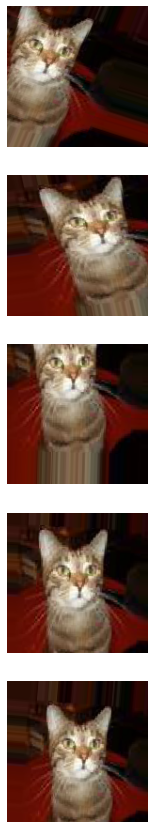

In [23]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    class_mode='binary'
)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [25]:
model  = Sequential([
    Input(shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    Conv2D(16,3,padding='same',activation='relu'),
    MaxPooling2D(),
    Conv2D(32,3,padding='same',activation='relu'),
    MaxPooling2D(),
    Conv2D(64,3,padding='same',activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(2),


])

model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 64)      

In [26]:
from math import ceil
steps_per_epochs = ceil(len(train_data_gen)/batch_size)
steps_per_epochs

1

In [27]:
validation_steps = ceil(len(val_data_gen)/batch_size)
validation_steps

1

In [28]:
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
)

Epoch 1/50
16/16 [==============================] - 27s 1s/step - loss: 0.8253 - accuracy: 0.5085 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 2/50
16/16 [==============================] - 19s 1s/step - loss: 0.6925 - accuracy: 0.5260 - val_loss: 0.6902 - val_accuracy: 0.5920
Epoch 3/50
16/16 [==============================] - 18s 1s/step - loss: 0.6891 - accuracy: 0.5435 - val_loss: 0.6793 - val_accuracy: 0.5690
Epoch 4/50
16/16 [==============================] - 17s 1s/step - loss: 0.6866 - accuracy: 0.5345 - val_loss: 0.6894 - val_accuracy: 0.5050
Epoch 5/50
16/16 [==============================] - 17s 1s/step - loss: 0.6856 - accuracy: 0.5455 - val_loss: 0.6746 - val_accuracy: 0.5990
Epoch 6/50
16/16 [==============================] - 17s 1s/step - loss: 0.6717 - accuracy: 0.5970 - val_loss: 0.6519 - val_accuracy: 0.6260
Epoch 7/50
16/16 [==============================] - 17s 1s/step - loss: 0.6596 - accuracy: 0.6100 - val_loss: 0.6385 - val_accuracy: 0.6310
Epoch 8/50
16/16 [==

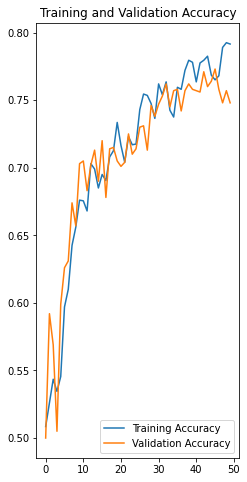

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# 
plt.show()

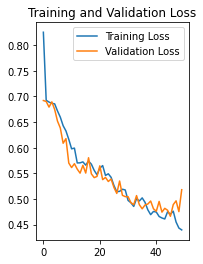

In [32]:
plt.subplot(1,2,1)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
predictions = model.predict(test_data_gen)
probabilities = [1 if a[0]<a[1] else 0 for a in predictions]

1/1 [==============================] - 0s 417ms/step


In [34]:
print(len(probabilities))

50


In [35]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability,answer in zip(probabilities,answers):
  if round(probability) == answer:
    correct += 1

percentage_identified = (correct/len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified*100,2)}%"
      f"of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge")

else:
  print("You haven't passed yet. Your model should identify at least 63% of the images.keep trying.You will get it !")

Your model correctly identified 76.0%of the images of cats and dogs.
You passed the challenge
